Preparation

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.4 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import http.client
import json
import csv
import os
from textblob import TextBlob
import numpy as np
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from textblob import TextBlob
#import shap
import spacy
import re
from dateutil import tz
from pytz import timezone
import pytz
from transformers import BertTokenizer, GPT2Tokenizer, TFGPT2Model, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load pre_categrized data for training models

In [ ]:
df_reddit = pd.read_csv('/content/drive/MyDrive/Reddit_Data.csv')
df_r = df_reddit.loc[(df_reddit['category'] == 1) | (df_reddit['category'] == -1)]
df_r.loc[df_r['category'] == -1,'category'] = 0
df_r.shape

Train BERT model

In [ ]:
bert = df_r.copy()
bert.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
bert.head()

,DATA_COLUMN,LABEL_COLUMN
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,0
4,for your own benefit you may want read living ...,1
5,you should all sit down together and watch the...,0


In [ ]:
bert.shape

(24107, 2)

In [ ]:
bert['DATA_COLUMN'] = bert['DATA_COLUMN'].astype(str)

In [ ]:
train_bert, test_bert = train_test_split(bert, test_size=0.3)

In [ ]:
train_bert.shape

(16874, 2)

In [ ]:
InputExample(guid=None,
             text_a = " ",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a=' ', text_b=None, label=1)

In [ ]:
model_bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
model_bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train_bert, test_bert, DATA_COLUMN, LABEL_COLUMN)
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
#train_data = train_data.shuffle(100).batch(32).repeat(2)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_InputExamples.shape

(16874,)

In [ ]:
train_InputExamples.head()

19755    InputExample(guid=None, text_a='aib extremely ...
20712    InputExample(guid=None, text_a='what fucking h...
15600    InputExample(guid=None, text_a='this indeed ho...
12381    InputExample(guid=None, text_a='hello thanks f...
35665    InputExample(guid=None, text_a=' was bright co...
dtype: object

In [ ]:
batch_size=32
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
tf.keras.callbacks.EarlyStopping

keras.callbacks.EarlyStopping

In [ ]:
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

model_bert.fit(train_data, batch_size=batch_size, epochs=15, validation_data=validation_data, callbacks=[early_stop])

Epoch 1/15
528/528 [==============================] - 530s 912ms/step - loss: 0.3619 - accuracy: 0.8358 - val_loss: 0.2355 - val_accuracy: 0.9034
Epoch 2/15
528/528 [==============================] - 477s 903ms/step - loss: 0.1643 - accuracy: 0.9356 - val_loss: 0.2351 - val_accuracy: 0.9159
Epoch 3/15
528/528 [==============================] - 477s 903ms/step - loss: 0.0841 - accuracy: 0.9704 - val_loss: 0.2570 - val_accuracy: 0.9208
Epoch 4/15
528/528 [==============================] - 477s 903ms/step - loss: 0.0493 - accuracy: 0.9832 - val_loss: 0.2644 - val_accuracy: 0.9240
Epoch 5/15
528/528 [==============================] - 476s 901ms/step - loss: 0.0328 - accuracy: 0.9886 - val_loss: 0.3121 - val_accuracy: 0.9235
Epoch 6/15
528/528 [==============================] - 476s 902ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.3263 - val_accuracy: 0.9202
Epoch 7/15
528/528 [==============================] - 476s 902ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.3044 -

In [ ]:
score, acc = model_bert.evaluate(validation_data, batch_size=batch_size)

227/227 [==============================] - 64s 280ms/step - loss: 0.3064 - accuracy: 0.9229


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.3064226508140564
Test accuracy: 0.9228535890579224


In [ ]:
test_bert.head()

,DATA_COLUMN,LABEL_COLUMN
3983,hahahaha bedi you have only yourself blame,1
7805,been many states india and haryana relatively ...,1
24188,while yes this get votes this step much better...,1
26706,queste storie dei carabinieri polizia municipa...,0
24281,big true,1


In [ ]:
# Set batch size and initialize predictions array
batch_size = 32
all_predictions = np.empty((0,))

# Initialize tqdm with the total number of comments
progress_bar = tqdm(total=len(test_bert))

# Loop through the comments in batches
for i in range(0, len(test_bert), batch_size):
    # Get the batch of comments
    batch = test_bert['DATA_COLUMN'][i:i+batch_size].tolist()
    # Tokenize the batch
    tf_batch = tokenizer(batch, max_length=128, padding=True, truncation=True, return_tensors='tf')
    # Make predictions on the batch
    tf_outputs = model_bert(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = tf.argmax(tf_predictions, axis=1).numpy()
    # Concatenate the predictions to the all_predictions array
    all_predictions = np.concatenate((all_predictions, labels))
    
    # Update the tqdm progress bar with the number of comments processed in this batch
    progress_bar.update(len(batch))

# Close the tqdm progress bar
progress_bar.close()

# Add the predictions array as a last column to the comment1 dataframe
test_bert['predictions_bert'] = all_predictions.astype(int)

100%|██████████| 7233/7233 [01:07<00:00, 107.55it/s]


In [ ]:
test_bert.head()

,DATA_COLUMN,LABEL_COLUMN,predictions_bert
3983,hahahaha bedi you have only yourself blame,1,1
7805,been many states india and haryana relatively ...,1,1
24188,while yes this get votes this step much better...,1,1
26706,queste storie dei carabinieri polizia municipa...,0,0
24281,big true,1,1


In [ ]:
true_labels = np.array(test_bert['LABEL_COLUMN'])
predicted_labels = np.array(test_bert['predictions_bert'])
#predicted_labels = np.argmax(np.array(test_bert['predictions_bert']), axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
def predict_tweet_sentiment(score):
    return (score > 0.5).astype("int32")
scores = model.predict(X_val)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2494
           1       0.93      0.96      0.94      4739

    accuracy                           0.92      7233
   macro avg       0.92      0.91      0.91      7233
weighted avg       0.92      0.92      0.92      7233



Text(51.0, 0.5, 'Predicted label')

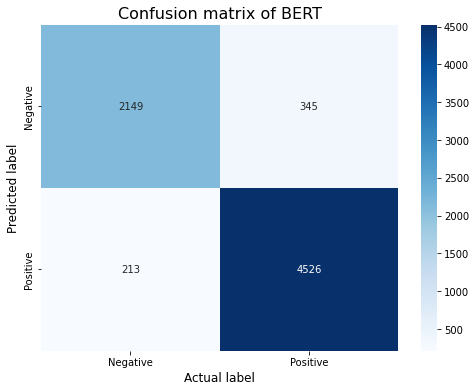

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix of BERT', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
df_1 = test_bert.copy()
df_1['correct'] = df_1.apply(lambda x: 1 if x['LABEL_COLUMN'] == x['predictions_bert'] else 0, axis=1)


In [ ]:
df_1.shape

(7233, 4)

In [ ]:
df_fault = df_1[df_1['correct']==0]

In [ ]:
df_fault.shape

(618, 4)

In [ ]:
max_features = 3000
maxlen = 128  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_fault['DATA_COLUMN'].values)

In [ ]:
word_counts_fault = tokenizer.word_counts
type(word_counts_fault)

collections.OrderedDict

In [ ]:
df_t = pd.DataFrame(word_counts_fault, index=[0])

In [ ]:
df_t1 = df_t.T
df_t1.to_csv('/content/drive/MyDrive/fault.csv', index=True)

In [ ]:
df_t1.shape

(8937, 1)

In [ ]:
max_features = 3000
maxlen = 128  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(test_bert['DATA_COLUMN'].values)

In [ ]:
word_counts_all = tokenizer.word_counts
df_ta = pd.DataFrame(word_counts_all, index=[0])

In [ ]:
df_t2 = df_ta.T
df_t2.to_csv('/content/drive/MyDrive/all.csv', index=True)

Load downloaded 2021 and 2022 Reddit comments related with labour and work, predict with trained BERT model

In [ ]:
comment_work1 = pd.read_json("/content/drive/MyDrive/comments2021_work.txt")
comment_work2 = pd.read_json("/content/drive/MyDrive/comments2022_work.txt")
comment_labour1 = pd.read_json("/content/drive/MyDrive/comments2021_labor.txt")
comment_labour2 = pd.read_json("/content/drive/MyDrive/comments2022_labor.txt")
frames = [comment_work1, comment_work2, comment_labour1, comment_labour2]
comment = pd.concat(frames)
comment.shape

(173867, 11)

In [ ]:
comment['created_utc'] = pd.to_datetime(comment['created_utc'])
comment["post_id"] = comment["link_id"].str.split("_").str[-1]
comment['body'] = comment['body'].astype(str)
comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173867 entries, 0 to 32945
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   created_utc            173867 non-null  datetime64[ns]
 1   commentID              173867 non-null  object        
 2   link                   173867 non-null  object        
 3   is_submitter           173867 non-null  object        
 4   author                 173867 non-null  object        
 5   author_flair_richtext  173867 non-null  object        
 6   link_id                173867 non-null  object        
 7   parent_id              173867 non-null  object        
 8   score                  173867 non-null  int64         
 9   body                   173867 non-null  object        
 10  is_submitier           173867 non-null  object        
 11  post_id                173867 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
me

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Set batch size and initialize predictions array
batch_size = 32
all_predictions = np.empty((0,))

# Initialize tqdm with the total number of comments
progress_bar = tqdm(total=len(comment))

# Loop through the comments in batches
for i in range(0, len(comment), batch_size):
    # Get the batch of comments
    batch = comment['body'][i:i+batch_size].tolist()
    # Tokenize the batch
    tf_batch = tokenizer(batch, max_length=128, padding=True, truncation=True, return_tensors='tf')
    # Make predictions on the batch
    tf_outputs = model_bert(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = tf.argmax(tf_predictions, axis=1).numpy()
    # Concatenate the predictions to the all_predictions array
    all_predictions = np.concatenate((all_predictions, labels))
    
    # Update the tqdm progress bar with the number of comments processed in this batch
    progress_bar.update(len(batch))

# Close the tqdm progress bar
progress_bar.close()

# Add the predictions array as a last column to the comment1 dataframe
comment['predictions_bert'] = all_predictions.astype(int)

100%|██████████| 173867/173867 [21:02<00:00, 137.75it/s]


In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_bert.csv', index=False)